# Step 1 : Importing important libraries


In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns    
import missingno as missno
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import auc, roc_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC

# Step 2: Load the data

In [121]:
train = pd.read_csv('cs-training.csv')
test = pd.read_csv('cs-test.csv')
train.head(10)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


## Dropping the unnamed column since it has no use for prediction 

In [122]:
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

# Step 3 : Understanding the data
## Seeing the distribution of dataset in order to understand the data.

In [91]:
variables = pd.DataFrame(columns=['Variable','Number of unique values','Number of nulls', 'Values'])

for i, var in enumerate(train.columns):
    variables.loc[i] = [var, train[var].nunique(), train[var].isnull().sum(), train[var].unique().tolist()]
v_dict = pd.read_excel('Data Dictionary.xls', index_col=0)
variables.set_index('Variable').join(v_dict)

,Number of unique values,Number of nulls,Values,Unnamed: 1,Unnamed: 2
Variable,,,,,
SeriousDlqin2yrs,2,0,"[1, 0]",Person experienced 90 days past due delinquenc...,Y/N
RevolvingUtilizationOfUnsecuredLines,125728,0,"[0.766126609, 0.957151019, 0.65818014, 0.23380...",Total balance on credit cards and personal lin...,percentage
age,86,0,"[45, 40, 38, 30, 49, 74, 57, 39, 27, 51, 46, 7...",Age of borrower in years,integer
NumberOfTime30-59DaysPastDueNotWorse,16,0,"[2, 0, 1, 3, 4, 5, 7, 10, 6, 98, 12, 8, 9, 96,...",Number of times borrower has been 30-59 days p...,integer
DebtRatio,114194,0,"[0.802982129, 0.121876201, 0.085113375, 0.0360...","Monthly debt payments, alimony,living costs di...",percentage
MonthlyIncome,13594,29731,"[9120.0, 2600.0, 3042.0, 3300.0, 63588.0, 3500...",Monthly income,real
NumberOfOpenCreditLinesAndLoans,58,0,"[13, 4, 2, 5, 7, 3, 8, 9, 6, 10, 14, 22, 17, 1...",Number of Open loans (installment like car loa...,integer
NumberOfTimes90DaysLate,19,0,"[0, 1, 3, 2, 5, 4, 98, 10, 9, 6, 7, 8, 15, 96,...",Number of times borrower has been 90 days or m...,integer
NumberRealEstateLoansOrLines,28,0,"[6, 0, 1, 3, 4, 2, 5, 8, 7, 9, 17, 15, 10, 12,...",Number of mortgage and real estate loans inclu...,integer


### Representing number of null column in terms of percentage for each column to check if percentage of null cells is more than 10% or not. If yes will try to remove that column

In [123]:
for i in range(train.shape[1]):
    n_miss = train.iloc[:,i].isnull().sum()
    perc = n_miss / train.shape[0] * 100
    print('%d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

0, Missing: 0 (0.0%)
1, Missing: 0 (0.0%)
2, Missing: 0 (0.0%)
3, Missing: 0 (0.0%)
4, Missing: 0 (0.0%)
5, Missing: 29731 (19.8%)
6, Missing: 0 (0.0%)
7, Missing: 0 (0.0%)
8, Missing: 0 (0.0%)
9, Missing: 0 (0.0%)
10, Missing: 3924 (2.6%)


### Filling the missing cell value with median of values of that column for better dataset

In [124]:
train['MonthlyIncome'] = train['MonthlyIncome'].fillna(train['MonthlyIncome'].median())
test['MonthlyIncome'] = test['MonthlyIncome'].fillna(test['MonthlyIncome'].median())

train['NumberOfDependents'] = train['NumberOfDependents'].fillna(train['NumberOfDependents'].median())
test['NumberOfDependents'] = test['NumberOfDependents'].fillna(test['NumberOfDependents'].median())

# Step 5 : Removing skewness
### Skewness is a measure of symmetry, or more precisely, the lack of symmetry. · If the skewness is between -0.5 and 0.5, the data are fairly symmetrical · If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed · If the skewness is less than -1 or greater than 1, the data are highly skewed

In [125]:
skew =train.skew().sort_values(ascending =False )
skew2= pd.DataFrame({'skew':skew})
skew2.head(10)

,skew
MonthlyIncome,127.121696
RevolvingUtilizationOfUnsecuredLines,97.631574
DebtRatio,95.157793
NumberOfTime60-89DaysPastDueNotWorse,23.331743
NumberOfTimes90DaysLate,23.087345
NumberOfTime30-59DaysPastDueNotWorse,22.597108
NumberRealEstateLoansOrLines,3.482484
SeriousDlqin2yrs,3.468857
NumberOfDependents,1.626059
NumberOfOpenCreditLinesAndLoans,1.215314


### Our Data is Highly skewed , we corrected values which are highly skewed below before modeling
### Before correcting, monthly income dist plot.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


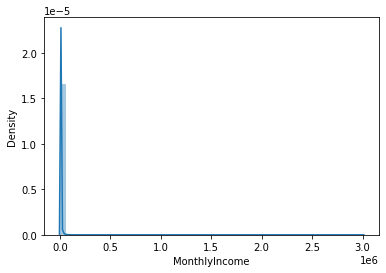

In [126]:
ds = sns.distplot(train['MonthlyIncome'])

### After correcting, monthly income dist plot.

-4.937609756385132


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


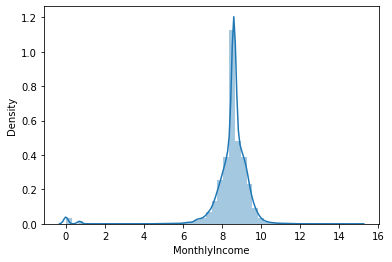

In [127]:
amount_corrected= np.log(train['MonthlyIncome' ]+1)
train['MonthlyIncome'] = amount_corrected.skew()
print(amount_corrected.skew())
ds = sns.distplot(amount_corrected)

### Similarly for other values.

11.704798483586039


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


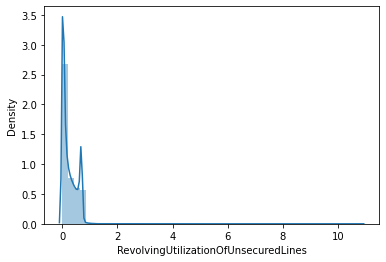

In [128]:
amount_corrected= np.log(train['RevolvingUtilizationOfUnsecuredLines']+1)
train['RevolvingUtilizationOfUnsecuredLines'] = amount_corrected.skew()
print(amount_corrected.skew())
ds = sns.distplot(amount_corrected)

# Removing Outliers
### Identifying outliers in data is an important part of statistical analyses. One simple rule of thumb (due to John Tukey) for finding outliers is based on the quartiles of the data: the first quartile Q1 is >= 0.25 of the data, the second quartile Q2 >= 0.50 of the data, and the third quartile Q3 >= 0.75 of the data. The interquartile range is IQR = Q3-Q1.

In [129]:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1

training_val = train.select_dtypes(exclude=['category']) 
df_out = training_val[~((training_val < (Q1 - 1.5 * IQR))|(training_val > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df_out.shape)

(79882, 11)


# Arranging the high correlation values with the probability of loan accordingly

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Features's correlation with Target Feature
SeriousDlqin2yrs 1.0
RevolvingUtilizationOfUnsecuredLines nan
age -0.09644051844401222
NumberOfTime30-59DaysPastDueNotWorse 0.2522709715697707
DebtRatio 0.0168236921881525
MonthlyIncome nan
NumberOfOpenCreditLinesAndLoans -0.03246025235750907
NumberOfTimes90DaysLate 0.3396965173417035
NumberRealEstateLoansOrLines -0.03169693388388846
NumberOfTime60-89DaysPastDueNotWorse 0.2756871735837887
NumberOfDependents 0.04408369395260646


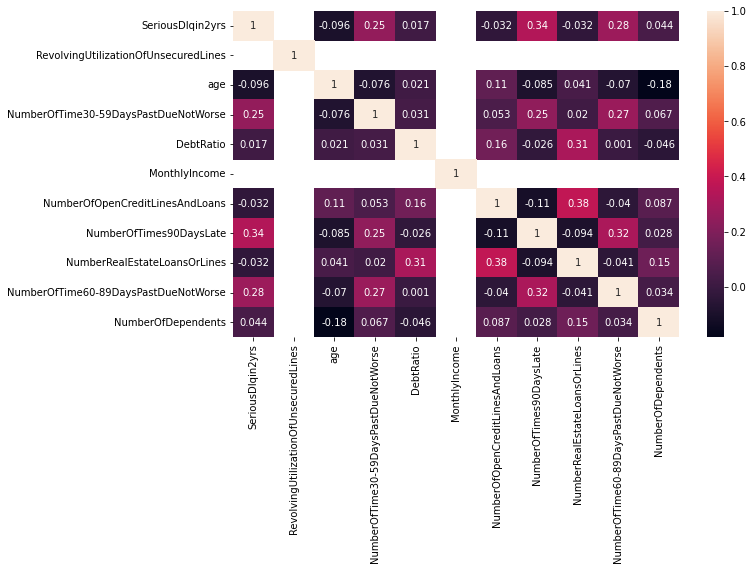

In [99]:
correlation = train.corr(method='kendall')
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True)
print('Features having correlation with Target Feature')
for indx, cor in enumerate(correlation['SeriousDlqin2yrs']):
    print(correlation.index[indx], cor)

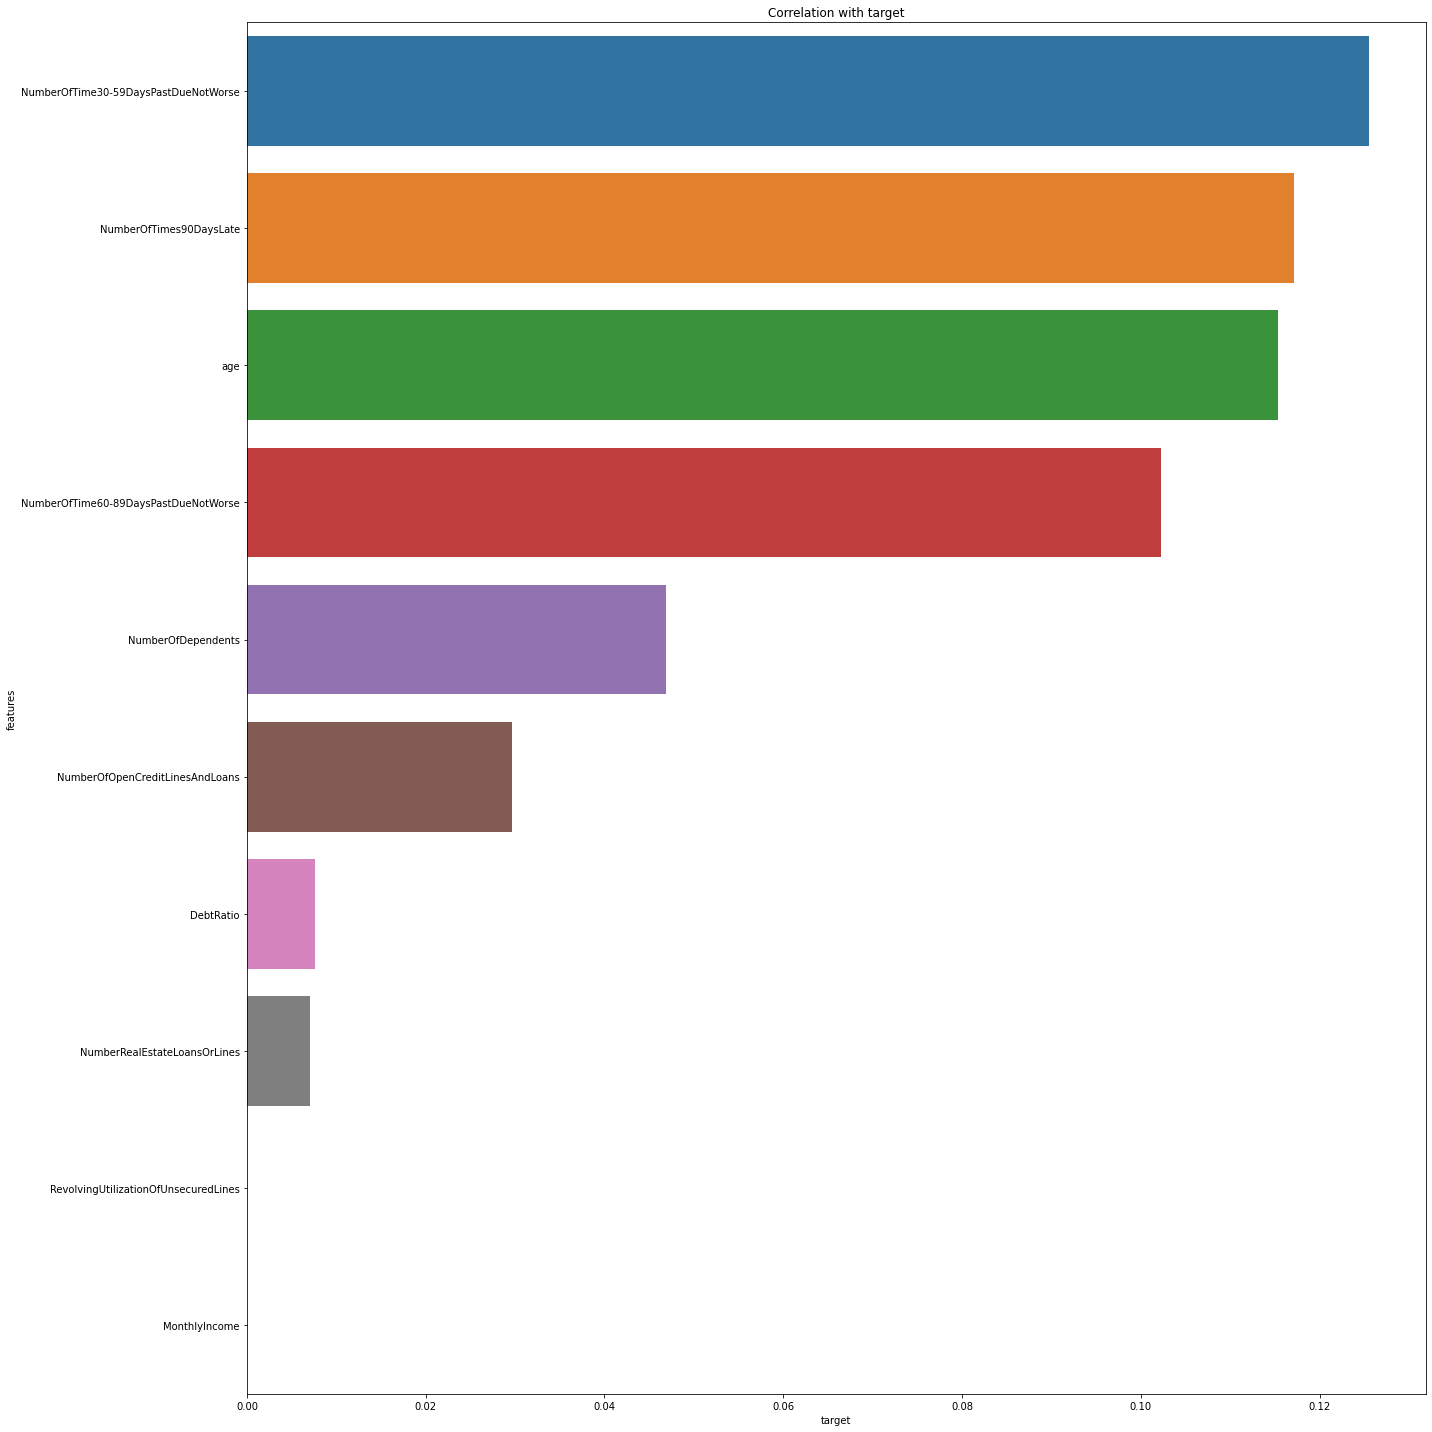

In [100]:
corrmat = train.corr()
corr_with_target = corrmat['SeriousDlqin2yrs'].apply(abs).sort_values(ascending=False)
corr_with_target.drop(['SeriousDlqin2yrs'], inplace=True)
df = pd.DataFrame(data={'features': corr_with_target.index, 'target': corr_with_target.values})
plt.figure(figsize=(20, 20))
sns.barplot(x="target", y="features", data=df)
plt.title('Correlation with target')
plt.tight_layout()
plt.show()

# Resolving the problem of multicollinearity

In [101]:
train['total_past_due'] = train['NumberOfTime30-59DaysPastDueNotWorse'] + (2 * train['NumberOfTime60-89DaysPastDueNotWorse']) + (3*train['NumberOfTimes90DaysLate'])
test['total_past_due'] = test['NumberOfTime30-59DaysPastDueNotWorse'] + (2 * test['NumberOfTime60-89DaysPastDueNotWorse']) + (3*test['NumberOfTimes90DaysLate'])

train.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'], axis=1, inplace=True)
test.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'], axis=1, inplace=True)

# Model building and Data modeling

### Our target value is SeriousDlqin2yrs so we will store in variable y and rest data in X for prediction

In [102]:
x = train.drop('SeriousDlqin2yrs', axis=1)
y = train['SeriousDlqin2yrs']
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = 0.1, stratify=y, random_state=1234)

In [103]:
base_model = GradientBoostingClassifier(n_estimators=250)
skf = StratifiedKFold(n_splits=10)
scores = cross_val_score(base_model, xtrain, ytrain, scoring = 'roc_auc', cv=skf) 
scores

array([0.85076803, 0.8413539 , 0.84034363, 0.83415609, 0.83707987,
       0.840689  , 0.84867917, 0.83255642, 0.84752759, 0.84660211])

In [105]:
def compute_model(model_obj, params):
    grid_model = GridSearchCV(model_obj, params, cv=None)
    grid_model.fit(xtrain, ytrain)
    ypred_train = grid_model.best_estimator_.predict_proba(xtrain)[:,1]
    ypred = grid_model.best_estimator_.predict_proba(xtest)[:,1]

    fpr, tpr, thresholds = roc_curve(ytest, ypred, pos_label = 1)
    score = auc(fpr, tpr)

    result = {'auc':score}
    return result, grid_model.best_estimator_

#LogisticRegression

In [106]:
lr_params = {}
lr = LogisticRegression()
result, best_estimator = compute_model(lr, lr_params)

model_results = dict()
model_results['Logistic Regression'] = [result, best_estimator]
print('Logistic Regression', result)

Logistic Regression {'auc': 0.8001022651841575}


#XGBoost

In [107]:
xg_param = {}
xg = XGBClassifier()
result, best_estimator = compute_model(xg, xg_param)

model_results['XGBoost'] = [result, best_estimator]
print('XGBoost', result)

XGBoost {'auc': 0.8554715221343185}


#GradientBoost

In [108]:
gb_param = {} 
gb = GradientBoostingClassifier()
result, best_estimator = compute_model(gb, gb_param)

model_results['GradientBoosting'] = [result, best_estimator]
print('GradientBoosting', result)

GradientBoosting {'auc': 0.8560802909553828}


#Adaboost

In [109]:
ab_param = {} 
ab = AdaBoostClassifier()
result, best_estimator = compute_model(ab, ab_param)

model_results['AdaBoost'] = [result, best_estimator]
print('AdaBoost', result)

AdaBoost {'auc': 0.8525642975339183}


#Decision Tree

In [110]:
dt_param =  {'max_depth': [3, 4, 5, 6, 7, 8]}
dt = DecisionTreeClassifier()
result, best_estimator = compute_model(dt, dt_param)

model_results['DecisionTree'] = [result, best_estimator]
print('DecisionTree', result)

DecisionTree {'auc': 0.8390682421550094}


# Results

In [111]:
results = [[model_name, results[0]['auc'], results[1]] for model_name, results in model_results.items()]
results = pd.DataFrame(results, columns = ['model_name', 'auc', 'best_model'])
results

,model_name,auc,best_model
0,Logistic Regression,0.800102,LogisticRegression()
1,XGBoost,0.855472,XGBClassifier()
2,GradientBoosting,0.856080,([DecisionTreeRegressor(criterion='friedman_ms...
3,AdaBoost,0.852564,"(DecisionTreeClassifier(max_depth=1, random_st..."
4,DecisionTree,0.839068,DecisionTreeClassifier(max_depth=7)


Text(0.5, 1.0, 'Comparison of Model Performance')

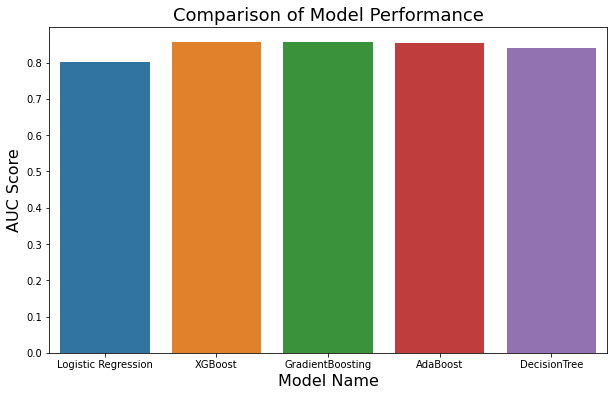

In [112]:
plt.figure(figsize=(10, 6))
sns.barplot(x = 'model_name', y = 'auc', data = results)
plt.xlabel('Model Name', size=16)
plt.ylabel('AUC Score', size=16)
plt.title('Comparison of Model Performance', size=18)

In [113]:
gb = results['best_model'][2]
xg = results['best_model'][1]
ad = results['best_model'][3]

all_models = (('gb', gb), ('xg', xg))

model = StackingClassifier(estimators = all_models, final_estimator = gb)
model.fit(xtrain, ytrain)
ypred_train = model.predict_proba(xtrain)[:,1]
ypred = model.predict_proba(xtest)[:,1]
fpr, tpr, thresholds = roc_curve(ytest, ypred, pos_label = 1)
score = auc(fpr, tpr)
score

0.8546583582823011

# ROC
AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease. The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.

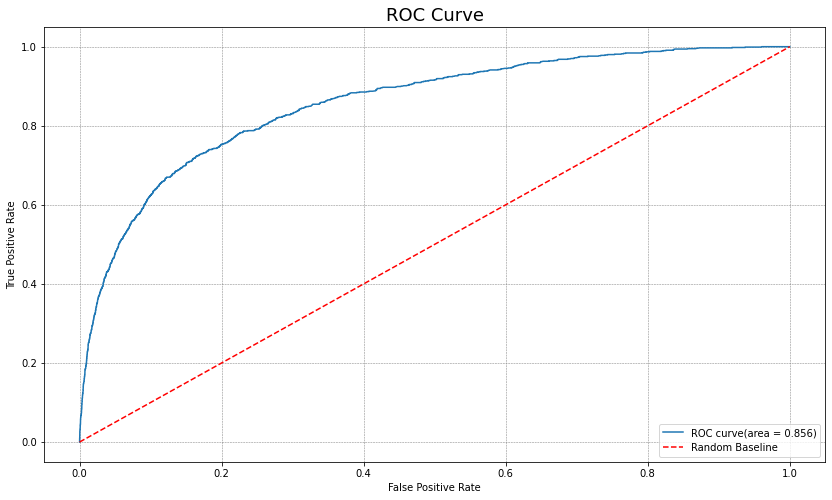

In [114]:
ypred = gb.predict_proba(xtest)[:,1]
fpr, tpr, thresholds = roc_curve(ytest, ypred, pos_label = 1)
score = auc(fpr, tpr)
plt.figure(figsize = (14, 8))
plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % score)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve", size=18)
plt.legend(loc="lower right")
